# Complements of Machine Learning : Project 1

Made by Alexandra de Carvalho, Luis Costa e Nuno Pedrosa

## Data Preprocessing

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from hypopt import GridSearch # to do gridsearch without cross validation. sklearn does not support this
from mlxtend.evaluate import mcnemar_table
from mlxtend.plotting import checkerboard_plot
from mlxtend.evaluate import mcnemar
from mlxtend.evaluate import paired_ttest_5x2cv
from mlxtend.evaluate import paired_ttest_kfold_cv

import numpy as np
import pandas as pd
import seaborn as sns

import joblib # to save and load the models

In [37]:
data = pd.read_csv('data/adult.data', names=['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                                              'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                                              'hrs_per_week', 'native_country', 'income'])

data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hrs_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [38]:
data_test = pd.read_csv('data/adult.test', names=['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                                              'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                                              'hrs_per_week', 'native_country', 'income'])
data_test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hrs_per_week,native_country,income
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [39]:
data_test.dropna(inplace=True)

In [40]:
# There's no nans
#data.isna().sum()

In [41]:
data = pd.concat([data, data_test], ignore_index=True)

In [42]:
data.income.unique()

array([' <=50K', ' >50K', ' <=50K.', ' >50K.'], dtype=object)

In [43]:
data['income'] = data['income'].replace({' <=50K.': ' <=50K', ' >50K.': ' >50K'})
data.income.unique()

array([' <=50K', ' >50K'], dtype=object)

In [44]:
# in this column the order does not matter
data.workclass.unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [45]:
# we must keep the order in this encoding
data.education.unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

In [46]:
edu = [' Preschool', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 12th',
       ' HS-grad', ' Prof-school', ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' Bachelors',
       ' Masters',' Doctorate']

In [47]:
data.occupation.unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [48]:
# auxiliar calculations to decide how to order the occupations columns
aux = data[['occupation', 'income']].copy()
a = pd.DataFrame(aux.groupby(['occupation', 'income']).size())
a = {'clerical': (756/4784), 'af': (4/10), 'craft': (1355/4665), 'manager': (2867/3117), 'farm': (172/1308),
     'clean': (135/1911), 'mach': (365/2605), 'other': (196/4612), 'priv': (3/229), 'prof': (2704/3304),
     'prot_serv': (307/669), 'sales': (1455/3953), 'tech':(411/1009), 'transport': (478/1838) }
# sorted by the ratio of >50k / <= 50k by profession
dict(sorted(a.items(), key=lambda item: item[1]))

{'priv': 0.013100436681222707,
 'other': 0.042497831743278404,
 'clean': 0.0706436420722135,
 'farm': 0.13149847094801223,
 'mach': 0.1401151631477927,
 'clerical': 0.15802675585284282,
 'transport': 0.2600652883569097,
 'craft': 0.2904608788853162,
 'sales': 0.36807487983809767,
 'af': 0.4,
 'tech': 0.40733399405351833,
 'prot_serv': 0.4588938714499253,
 'prof': 0.8184019370460048,
 'manager': 0.919794674366378}

In [49]:
ocupation = [' Priv-house-serv', ' Other-service', ' Handlers-cleaners', ' Farming-fishing', ' Machine-op-inspct',
             ' Adm-clerical', ' Transport-moving', ' Craft-repair', ' Sales', ' Armed-Forces', ' Tech-support',
             ' Protective-serv', ' Prof-specialty', ' Exec-managerial']

In [50]:
data.loc[data.workclass == ' ?']

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hrs_per_week,native_country,income
27,54,?,180211.0,Some-college,10.0,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0.0,0.0,60.0,South,>50K
61,32,?,293936.0,7th-8th,4.0,Married-spouse-absent,?,Not-in-family,White,Male,0.0,0.0,40.0,?,<=50K
69,25,?,200681.0,Some-college,10.0,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
77,67,?,212759.0,10th,6.0,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,2.0,United-States,<=50K
106,17,?,304873.0,10th,6.0,Never-married,?,Own-child,White,Female,34095.0,0.0,32.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48682,61,?,265201.0,Some-college,10.0,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,14.0,United-States,<=50K
48769,21,?,212661.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
48800,73,?,144872.0,HS-grad,9.0,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,25.0,Canada,<=50K
48812,81,?,26711.0,Assoc-voc,11.0,Married-civ-spouse,?,Husband,White,Male,2936.0,0.0,20.0,United-States,<=50K


In [51]:
data.replace(' ?', np.NaN, inplace=True)
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [52]:
le = preprocessing.LabelEncoder()
sc = preprocessing.MaxAbsScaler()
oe = preprocessing.OrdinalEncoder(categories=[edu, ocupation])


In [53]:
def preprocess(df):
    mappings = {}
    y = df.income
    X = df.drop(columns=['income'])
    objList = X.select_dtypes(include="object").columns.to_list()
    y = le.fit_transform(y)
    
    for feat in objList:
        X[feat] = X[feat].astype('category')
        mappings[feat] = (X[feat].cat.categories, X[feat].cat.codes)
        X[feat] = X[feat].cat.codes
        
    X = sc.fit_transform(X)
    
    return X, y, mappings

In [54]:
X, y, mappings = preprocess(data)

In [55]:
def preprocessing_v3(df):
    y = df.income
    X = df.drop(columns=['income'])
    objList = X.select_dtypes(include="object").columns.to_list()
    objList.remove('education')
    y = le.fit_transform(y)
    X[['education', 'occupation']] = pd.DataFrame(oe.fit_transform(X[['education', 'occupation']]))
    X = pd.get_dummies(X, columns=['workclass', 'marital_status', 'relationship',
                                   'race', 'sex', 'native_country'])
    X = sc.fit_transform(X)
    
    return X, y

In [56]:
X_3, y_3 = preprocessing_v3(data)

In [57]:
X

array([[0.15277778, 0.83333333, 0.0520102 , ..., 0.        , 0.4040404 ,
        0.95      ],
       [0.22916667, 0.66666667, 0.05589842, ..., 0.        , 0.13131313,
        0.95      ],
       [0.14583333, 0.33333333, 0.14469002, ..., 0.        , 0.4040404 ,
        0.95      ],
       ...,
       [0.64583333, 0.33333333, 0.2515989 , ..., 0.        , 0.50505051,
        0.95      ],
       [0.6875    , 0.33333333, 0.05628757, ..., 0.        , 0.4040404 ,
        0.95      ],
       [0.625     , 0.5       , 0.12221417, ..., 0.        , 0.60606061,
        0.95      ]])

In [58]:
def preprocess_v2(df):
    y = df.income
    X = df.drop(columns=['income'])
    
    y = le.fit_transform(y)
    X = pd.get_dummies(X, columns=['workclass', 'education', 'marital_status', 'occupation', 'relationship',
                                   'race', 'sex', 'native_country'])
    X = sc.fit_transform(X)
    
    return X, y

In [27]:
X_2, y_2 = preprocess_v2(data)

# Random Forest

Cross validation allows estimating the expected prediction error. This is important to ensure the model built is a good one. We are interested in calculating the confidence intervals for different strategies: holdout method and K-Fold CV.  

### Confidence Intervals in Hold-out

#### Model

Holdout is the simplest strategy. It consists in dividing the data into 70-80% of training data and 30-20% of testing data (holdout sample). This testing data can be further divided into validation and test data, both samples of the same size.

In [ ]:
def train_rf_holdout(X_train_val, y_train_val):

    #hyper-parameter tunning
    param_grid = [
        {'criterion': ['gini','entropy'],
        'max_depth': [10,30,60,None],
        'max_leaf_nodes': [10,30,60,None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1,2,3],
        'min_samples_split': [2,4],
        'n_estimators': (500,800,1000,1200)}
    ]

    gs_rf = GridSearch(RandomForestClassifier(),param_grid=param_grid)
    gs_rf.fit(X_train_val, y_train_val)

    print(gs_rf.best_params)
    print(gs_rf.best_score)
    return gs_rf.best_estimator_

In [ ]:
# data splitting
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_3, y_3, test_size=0.15, random_state=0) #hold-out
X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.15, random_state=0) #hold-out

# final training and testing
model = train_rf_holdout(X_train_valid, y_train_valid)
model.fit(X_train_valid, y_train_valid)
y_test_pred = model.predict(X_test)

/home/alexa/.local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
0.861387148454383


#### Confidence Interval

Now let's see the confidence interval. For CI = 95%, z must be 1.96. The 95% confidence interval is commonly used, and it shows the range of values within which the true model accuracy is covered, with 95% of likelihood.

In [ ]:
acc_test = accuracy_score(y_test, y_test_pred)
print("Accuracy of",acc_test)

ci_test = 1.96 * np.sqrt((acc_test*(1-acc_test)) / y_test.shape[0])

test_lower = acc_test-ci_test
test_upper = acc_test+ci_test

print('%.1f confidence interval %.1f%% and %.1f%%' % (acc_test*100, test_lower*100, test_upper*100))

Accuracy of 0.8624705188679245
86.2 confidence interval 85.4% and 87.1%


### Confidence Intervals in Cross-Validation

#### Model

Cross-validation is a more advanced method because it trains the model on multiple train-test splits. This gives a better indication of how well the model will perform on unseen data.

In [24]:
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.3, random_state=0)

In [26]:
# Triyng with standard parameters
# With the third preprocess function (the one that got better results with knn)
RF_classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
RF_classifier.fit(X_3_train, y_3_train) 

RandomForestClassifier(n_estimators=1000, random_state=0)

In [27]:
all_accuracies_RF = cross_val_score(estimator=RF_classifier, X=X_3_train, y=y_3_train, cv=3)
print('cross_val_score: ', all_accuracies_RF)
print('Mean: ', all_accuracies_RF.mean())
print('Standard deviation: ', all_accuracies_RF.std())

cross_val_score:  [0.85083397 0.85064443 0.85034594]
Mean:  0.850608110498445
Standard deviation:  0.00020088409371489215


In [28]:
y_3_pred_standard = RF_classifier.predict(X_3_test)

In [29]:
print(confusion_matrix(y_3_test,y_3_pred_standard))
print(classification_report(y_3_test,y_3_pred_standard))
print('accuracy_score: ', accuracy_score(y_3_test, y_3_pred_standard))
print('ROC_AUC: ', roc_auc_score(y_3_test,y_3_pred_standard))

[[9519  739]
 [1235 2074]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     10258
           1       0.74      0.63      0.68      3309

    accuracy                           0.85     13567
   macro avg       0.81      0.78      0.79     13567
weighted avg       0.85      0.85      0.85     13567

accuracy_score:  0.8544998894376059
ROC_AUC:  0.7773670636355082


Searching for the best parameters:

In [31]:
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=0)),
])
parameters = {
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': [10,30,60,None],
    'clf__max_leaf_nodes': [10,30,60,None],
    'clf__max_features': ['auto', 'sqrt'],
    'clf__min_samples_leaf': [1,2,3],
    'clf__min_samples_split': [2,4],
    'clf__n_estimators': (500,800,1000,1200)
}

gs_rf = GridSearchCV(pipeline, parameters, cv=2, n_jobs=1, verbose=3)
gs_rf.fit(X_3_train, y_3_train)

print("Best parameters set:")
print(gs_rf.best_estimator_.steps)

Fitting 2 folds for each of 1536 candidates, totalling 3072 fits
[CV 1/2] END clf__criterion=gini, clf__max_depth=10, clf__max_features=auto, clf__max_leaf_nodes=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=500;, score=0.835 total time=   7.0s
[CV 2/2] END clf__criterion=gini, clf__max_depth=10, clf__max_features=auto, clf__max_leaf_nodes=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=500;, score=0.830 total time=   5.9s
[CV 1/2] END clf__criterion=gini, clf__max_depth=10, clf__max_features=auto, clf__max_leaf_nodes=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=800;, score=0.836 total time=   9.2s
[CV 2/2] END clf__criterion=gini, clf__max_depth=10, clf__max_features=auto, clf__max_leaf_nodes=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=800;, score=0.831 total time=   9.1s
[CV 1/2] END clf__criterion=gini, clf__max_depth=10, clf__max_features=auto, clf__max_leaf_nodes=10, clf__m

In [32]:
print(gs_rf.best_params_)
print(gs_rf.best_score_)
print(gs_rf.score(X_3_test, y_3_test))

{'clf__criterion': 'gini', 'clf__max_depth': 60, 'clf__max_features': 'auto', 'clf__max_leaf_nodes': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}
0.8575896601009024
0.8655561288420431


Best parameters:

{'clf__criterion': 'gini', 'clf__max_depth': 60, 'clf__max_features': 'auto', 'clf__max_leaf_nodes': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}

Classification Model with the best parameters

In [30]:
classifier_best = RandomForestClassifier(max_depth=60, min_samples_leaf=2, n_estimators=500,random_state=0) # The parameters that aren't here, the best are the standard ones
classifier_best.fit(X_3_train, y_3_train) 

RandomForestClassifier(max_depth=60, min_samples_leaf=2, n_estimators=500,
                       random_state=0)

In [31]:
all_accuracies_best = cross_val_score(estimator=classifier_best, X=X_3_train, y=y_3_train, cv=3)
print('cross_val_score: ', all_accuracies_best)
print('Mean: ', all_accuracies_best.mean())
print('Standard deviation: ', all_accuracies_best.std())

cross_val_score:  [0.86078469 0.85718347 0.85925505]
Mean:  0.859074401536736
Standard deviation:  0.0014757277085573543


In [32]:
y_pred_kfold = classifier_best.predict(X_3_test)

In [34]:
print(confusion_matrix(y_3_test,y_pred_kfold))
print(classification_report(y_3_test,y_pred_kfold))
print('accuracy_score: ', accuracy_score(y_3_test, y_pred_kfold))
print('ROC_AUC: ', roc_auc_score(y_3_test,y_pred_kfold))

[[9708  550]
 [1274 2035]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     10258
           1       0.79      0.61      0.69      3309

    accuracy                           0.87     13567
   macro avg       0.84      0.78      0.80     13567
weighted avg       0.86      0.87      0.86     13567

accuracy_score:  0.8655561288420431
ROC_AUC:  0.7806863666865996


Saving the model

In [35]:
# saving the model to disk
filename_rf = 'rf.sav'
joblib.dump(classifier_best, filename_rf)

['rf.sav']

In [60]:
# loading the model from disk
loaded_model = joblib.load('rf.sav')
result = loaded_model.score(X_3_test, y_3_test)
print(result)

/home/alexa/.local/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/alexa/.local/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


0.8655561288420431


#### Confidence Interval

Now let's see the confidence interval. For CI = 95%, z must be 1.96. The 95% confidence interval is commonly used, and it shows the range of values within which the true model accuracy is covered, with 95% of likelihood.

In [38]:
acc_test_kf = accuracy_score(y_3_test, y_pred_kfold)
print("Accuracy of",acc_test_kf)

ci_kfold = 1.96 * np.sqrt((acc_test_kf*(1-acc_test_kf)) / y_3_test.shape[0])

test_lower_kf = acc_test_kf-ci_kfold
test_upper_kf = acc_test_kf+ci_kfold

print('%.1f confidence interval %.1f%% and %.1f%%' % (acc_test_kf*100, test_lower_kf*100, test_upper_kf*100))

Accuracy of 0.8655561288420431
86.6 confidence interval 86.0% and 87.1%


### Analysis of Results

We can see that K-Fold yields better results because it has a higher confidence in a narrower classification interval.

# KNN

In [29]:
def train_knn(X_train, X_test, y_train, y_test):
    param_grid = [
        {'n_neighbors': [15, 17, 19, 21],
         'weights': ['uniform', 'distance'],
         'leaf_size': [2,3,4, 5,7],
         'p': [1,2] }
    ]

    knn = KNeighborsClassifier()

    gs_knn = GridSearchCV(knn,
                        param_grid=param_grid,
                        scoring='accuracy', n_jobs=-1,
                        cv=10) # 10-fold cross-validation

    gs_knn.fit(X_train, y_train)
    
    print(gs_knn.best_params_)
    print(gs_knn.best_score_)
    
    return gs_knn.best_estimator_

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# Using ordinal encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
train_knn(X_train, X_test, y_train, y_test)

In [ ]:
# Using onehot encoding
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.3, random_state=0)
train_knn(X_train2, X_test2, y_train2, y_test2)

In [48]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_3, y_3, test_size=0.3, random_state=0)
knn = train_knn(X_train3, X_test3, y_train3, y_test3)

{'leaf_size': 3, 'n_neighbors': 17, 'p': 2, 'weights': 'uniform'}
0.8360728237635439
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     10258
           1       0.70      0.58      0.63      3309

    accuracy                           0.84     13567
   macro avg       0.78      0.75      0.76     13567
weighted avg       0.83      0.84      0.83     13567

ROC_AUC:  0.748496673405468


In [52]:
knn_2 = train_knn(X_train3, X_test3, y_train3, y_test3)

{'leaf_size': 2, 'n_neighbors': 21, 'p': 1, 'weights': 'uniform'}
0.8357779907127589
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     10258
           1       0.70      0.58      0.63      3309

    accuracy                           0.84     13567
   macro avg       0.78      0.75      0.76     13567
weighted avg       0.83      0.84      0.83     13567

ROC_AUC:  0.7476875399816202


In [49]:
# saving the model to disk
filename = 'knn_2.sav'
joblib.dump(knn_2, filename)

['knn.sav']

In [33]:
# loading the model from disk
model_knn = joblib.load('knn.sav')
result = model_knn.score(X_3_test, y_3_test)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

## Comparing Classifiers

A t-test is a statistical test that is used to compare classifiers (pairwise comparison), by averaging the performances over the same test set. It is often used in hypothesis testing to determine whether the classifiers have an effect on the results. The null hypothesis (H0) is that the true difference between these group means is zero. The alternate hypothesis (Ha) is that the true difference is different from zero. Let's consider α=0.05, as it is a popular value for this.

### McNemar's Test

This test is a type of paired chi-square test of data with 1 degree of freedom. Degrees of freedom show how many 'free' data points are available in the test for making comparisons. The greater the degrees of freedom, the better the statistical test will work.

chi-squared: 198.858
p-value: 0.000


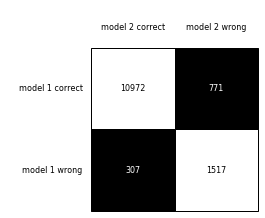

In [45]:
# Creating the 2x2 contingency table
mcnemar_tbl = mcnemar_table(y_target=y_test, y_model1=y_pred_kfold, y_model2=y_pred_knn)

# Visualizing the contingency table
brd = checkerboard_plot(mcnemar_tbl, figsize=(3, 3),fmt='%d',col_labels=['model 2 correct', 'model 2 wrong'],row_labels=['model 1 correct', 'model 1 wrong'])

# Executing the McNemar's test
chi2, p_value = mcnemar(ary=mcnemar_tbl)
print(f'chi-squared: {chi2:.3f}')
print(f'p-value: {p_value:.3f}')

Assuming that we conducted this test with a significance level of α=0.05, we can reject the null-hypothesis that both models perform equally well on this dataset, since the p-value (p<0.000) is smaller than α.

## 5x2 Cross-Validation Paired T Test

This statistics approximately follow a t distribution with 5 degrees of freedom.

In [ ]:
t, p = paired_ttest_5x2cv(estimator1=loaded_model,estimator2=model_knn,X=X_3, y=y_3,random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 19.921
p value: 0.000


Assuming that we conducted this test with a significance level of α=0.05, we can reject the null-hypothesis that both models perform equally well on this dataset, since the p-value (p<0.000) is smaller than α.

## Nested K-Fold Cross-Validation Paired T Test

This test uses 10 fold by default. It has k-1 degrees of freedom, therefore, 9.

In [61]:
t, p = paired_ttest_kfold_cv(estimator1=loaded_model,estimator2=model_knn,X=X_3, y=y_3,random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

Assuming that we conducted this test with a significance level of α=0.05, we can reject the null-hypothesis that both models perform equally well on this dataset, since the p-value (p<0.000) is smaller than α.